In [1]:
import sys 
sys.path.append('..')
import pandas as pd
from datetime import timedelta 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ngboost.scores import LogScore
from ngboost.distns import LogNormal
from forecast_swiss import remove_zeros 
from ngboost.learners import default_tree_learner
from epigraphhub.analysis.clustering import compute_clusters
from epigraphhub.analysis.forecast_models.ngboost_models import NGBModel
from epigraphhub.analysis.forecast_models.metrics import compute_metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, mean_squared_log_error as msle,
                             mean_absolute_percentage_error as mape)

{'dbname': 'epigraphhub', 'host': 'localhost', 'password': 'epigraph', 'port': 5432, 'username': 'epigraph'}


In [2]:
def get_clusters_swiss_article(t=0.3, end_date=None):
    """
    This function it was create to allow the reproduction of the results of the article.
    Params to get the list of clusters computed by the compute_cluster function.
    :params t: float. Thereshold used in the clusterization.
    :param end_date: string. Indicates the last day used to compute the cluster
    :returns: Array with the clusters computed.
    """
    df = pd.read_csv(
        f"data_article/data_to_get_clusters.csv"
    )

    df.set_index("datum", inplace=True)
    df.index = pd.to_datetime(df.index)

    if end_date != None:
        df = df.loc[:end_date]

    clusters = compute_clusters(
        df,
        ["georegion", "entries"],
        t=t,
        drop_values=["CH", "FL", "CHFL"],
        plot=True,
        smooth=True,
    )[1]

    return clusters

params_model = {
    "Base": default_tree_learner,
    "Dist": LogNormal,
    "Score": LogScore,
    "natural_gradient": True,
    "verbose": False,
    "col_sample": 0.9,
    "n_estimators": 100,
    "learning_rate": 0.05,
}

def train_article(
    target_curve_name,
    canton,
    path="../opt/models/saved_models/ml",
    ini_date="2020-03-01",
    end_date=None,
    parameters_model=params_model,
    predict_n=14,
    look_back=14,
):

    """
    This function it was create to allow the reproduction of the results of the article.
    Function to train the model for one georegion

    Important:
    * By default the function is using the clustering cantons and the data since 2020
    * For the predictor hospCapacity is used as predictor the column ICU_Covid19Patients

    :params canton: canton of interest
    :params predictors: variables that  will be used in model
    :params vaccine: It determines if the vaccine data from owid will be used or not
    :params smooth: It determines if data will be smoothed or not
    :params ini_date: Determines the beggining of the train dataset
    :params path: Determines  where the model trained will be saved
    :params update_data: Determines if the data from the Geneva hospital will be used.
                        this params only is used when canton = GE and target_curve_name = hosp.
    :params parameters_model: dict with the params that will be used in the ngboost
                             regressor model.
    :params predict_n: int. Number of days that will be predicted.
    :params look_back: int. Number of the last days that will be used to forecast the next days.

    :returns: None
    """

    target_name = f"{target_curve_name}_{canton}"

    # getting the data
    df = pd.read_csv(f"data_article/data_{canton}.csv")

    df.set_index("datum", inplace=True)

    df.index = pd.to_datetime(df.index)

    df = df.fillna(0)

    df[target_name] = remove_zeros(df[target_name].values)

    if any(df[target_name] > 1):
        
        m = NGBModel(look_back = look_back,
            predict_n = predict_n, 
            validation_split = 0.15, 
            early_stop = 5, params_model = params_model)
        

        m.train(
            target_name,
            df,
            ini_date=ini_date,
            path=path,
            end_date=end_date
        )

    else:
        print(
            f"The model to forecast {target_name} was not trained, since the series has no value bigger than one."
        )

    return

def forecast_article(
    target_curve_name,
    canton,
    end_date=None,
    path="../opt/models/saved_models/ml",
    predict_n=14,
    look_back=14,
):
    """
    This function it was create to allow the reproduction of the results of the article.
    Function to make the forecast for one canton, it will load pre trained models.

    Important:
    * By default the function is using the clustering cantons and the data since 2020
    * For the predictor hospCapacity is used as predictor the column ICU_Covid19Patients

    :params target_curve_name: string to indicate the target column of the predictions
    :params canton: string to indicate the interest canton
    :params predictors: variables that  will be used in model
    :params vaccine: It determines if the vaccine data from owid will be used or not
    :params smooth: It determines if data will be smoothed or not
    :params end_date: string. Determines from what day the forecast will be computed.
    :params path: string. Indicates where the models trained are saved.
    :params predict_n: int. Number of days that will be predicted.
    :params look_back: int. Number of the last days that will be used to forecast the next days.

    returns: Dataframe with the forecast for all the cantons
    """

    target_name = f"{target_curve_name}_{canton}"

    df = pd.read_csv(f"data_article/data_{canton}.csv")

    df.set_index("datum", inplace=True)

    df.index = pd.to_datetime(df.index)

    df = df.fillna(0)
    
    m = NGBModel(look_back = look_back,
            predict_n = predict_n, 
            validation_split = 0.15, 
            early_stop = 5, params_model = params_model)

    df_for = m.forecast(
        df,
        end_date=end_date,
        path=path,
    )

    return df_for

In [3]:
def plot_forecast(target_name, canton, df_for):
    
    dict_name = {'hosp': ['new hospitalizations', 'datum', 'entries', 'foph_hosp_d'],
                'total_hosp': ['Total Hospitalizations', 'date', 'total_covid19patients', 'foph_hospcapacity_d'], 
                'icu_patients': ['Total ICU patients', 'date', 'icu_covid19patients', 'foph_hospcapacity_d']}
    
    title = f'Forecast {dict_name[target_name][0]} in {canton}'
    
    df = pd.read_csv(f'data_article/data_{canton}.csv')
    
    df.set_index("datum", inplace = True)
    df = df.sort_index()
    df.index = pd.to_datetime(df.index)
    
    df = df.resample("D").mean()
    
    plt.figure()
    
    plt.plot(df.loc[df_for.index][f'{target_name}_{canton}'], label = 'Data', color = 'black')
    
    plt.plot(df_for['median'], label = 'Median', color = 'tab:orange')
    
    plt.fill_between(df_for.index, df_for.upper, df_for.lower, color = 'tab:orange', alpha = 0.5)
    
    plt.xlabel('Date')
    plt.ylabel('Incidence')
    
    plt.title(title)
    plt.xticks(rotation=25)
    plt.legend()
    plt.grid()
    plt.savefig(f'plots/forecast_{target_name}_{canton}.png', bbox_inches='tight')
    plt.show()
    
    # computing some metrics 
    df_metrics = pd.DataFrame(columns = ['metrics', 'forecast_error'] )
    
    metrics = ['mean_absolute_error',
               'mean_squared_error', 'root_mean_squared_error', 'mean_squared_log_error',
                'mean_absolute_percentage_error']
    
    df_metrics['metrics'] = metrics 
    
    y_true = df.loc[df_for.index][f'{target_name}_{canton}']
    
    y_for = df_for['median']
    
    df_metrics['forecast_error'] = [ 
                                mae(y_true, y_for),
                                mse(y_true, y_for),
                                mse(y_true, y_for, squared = False),
                                msle(y_true, y_for),
                                mape(y_true, y_for) ]
    
    df_metrics.to_csv(f'metrics/for_metrics_{target_name}_{canton}.csv')
    
    return df_metrics     

In [4]:
def train_forecast(target_curve_name = 'hosp', canton = 'GE',
                    predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'],
                    path = 'saved_models'):
    
    train_article(
    target_curve_name,
    canton,
    path = path,
    ini_date="2020-05-01",
    end_date = '2022-05-01')
    
    df_for = forecast_article(
    target_curve_name,
    canton,
    end_date = '2022-05-01', 
    path=path)
    
    df_m = plot_forecast(target_curve_name, canton, df_for)
    
    df_m.set_index('metrics', inplace = True)
    
    return df_for, df_m  
    
    

## New hospitalizations 

### Geneva

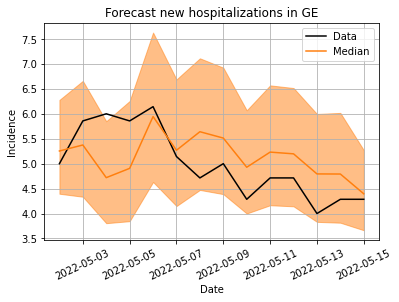

CPU times: user 3min 37s, sys: 645 ms, total: 3min 38s
Wall time: 3min 38s


In [5]:
%%time

df_f_ge, df_m_ge = train_forecast(target_curve_name = 'hosp', canton = 'GE',
                    predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'])

In [6]:
df_m_ge.head(6)

,forecast_error
metrics,
mean_absolute_error,0.556134
mean_squared_error,0.416611
root_mean_squared_error,0.645454
mean_squared_log_error,0.011320
mean_absolute_percentage_error,0.112106


### Berna

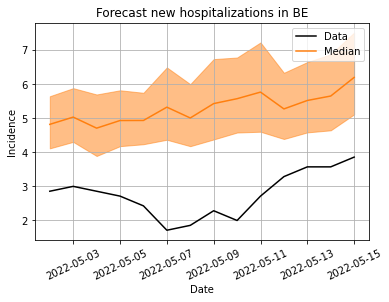

In [7]:
df_f_be, df_m_be = train_forecast(target_curve_name = 'hosp', canton = 'BE',
                    predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'])


In [8]:
df_m_be.head(6)

,forecast_error
metrics,
mean_absolute_error,2.529212
mean_squared_error,6.774327
root_mean_squared_error,2.602754
mean_squared_log_error,0.304570
mean_absolute_percentage_error,1.019402


### Zurich

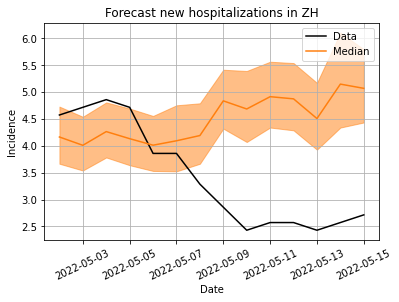

In [9]:
df_f_zh, df_m_zh = train_forecast(target_curve_name = 'hosp', canton = 'ZH',
                    predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'])


In [10]:
df_m_zh.head()

,forecast_error
metrics,
mean_absolute_error,1.390075
mean_squared_error,2.749719
root_mean_squared_error,1.658228
mean_squared_log_error,0.126696
mean_absolute_percentage_error,0.500669


Putting all the plots in the same plot:

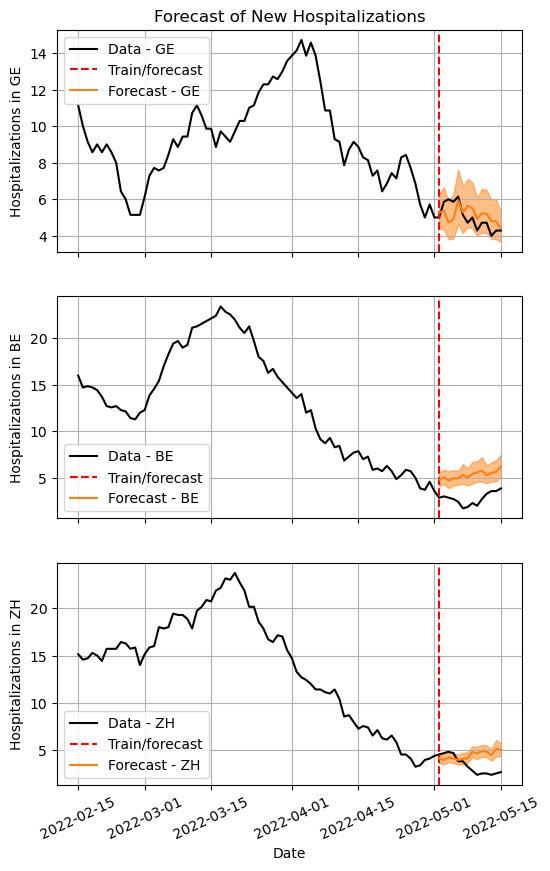

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize = (6,10), dpi = 100)

canton = 'GE'

curves = {'hosp': 'hosp', 'icu_patients': 'hospcapacity', 
              'total_hosp': 'hospcapacity'}

cantons = {'GE': df_f_ge , 'BE': df_f_be, 'ZH': df_f_zh}

axes = [ax1, ax2, ax3]

for (i,j) in zip(cantons.keys(), axes):
    canton = i
    ydata = pd.read_csv(f'data_article/data_{canton}.csv')
    ydata.set_index("datum", inplace = True)
    ydata = ydata.sort_index()
    ydata.index = pd.to_datetime(ydata.index)

    j.plot(ydata[f'hosp_{canton}'][:cantons[canton].index[-1]][-90:], color = 'black', label = f'Data - {canton}')
    
    j.axvline(cantons[canton].index[0], color = 'red', ls = '--', label = 'Train/forecast')

    j.fill_between(cantons[canton].index,cantons[canton].upper, cantons[canton].lower, color = 'tab:orange', alpha = 0.5)

    j.plot(cantons[canton]['median'], label = f'Forecast - {canton}', color = 'tab:orange')

    j.grid()
    j.legend()
    
    j.set_ylabel(f'Hospitalizations in {canton}')


ax1.set_title('Forecast of New Hospitalizations')

plt.xlabel('Date')
plt.xticks(rotation = 25)
plt.savefig(f'plots/forecast_ge_be_zh.png', bbox_inches = 'tight')
plt.show()